# Network Analysis on Auckland road data
### Import packages

In [1]:
import numpy as np
import pandas as pd
import osmnx as ox
import geopandas as gpd
from shapely.geometry import MultiPolygon, Point
from shapely.ops import transform
import pyproj
import networkx as nx
import math
import matplotlib.pyplot as plt
from pyproj import CRS
import itertools
import networkx as nx

### Importing the road network

In [3]:
auckland_path = "data/geographic/territorial/auckland_polygon_diy.gpkg"
auckland = gpd.read_file(auckland_path)
auckland = auckland.to_crs(crs=4326)
polygon = auckland.iloc[0]['geometry']

G = ox.graph.graph_from_polygon(polygon, network_type="walk", simplify = True)

#auck_network = ox.io.load_graphml("data/network_analysis/auckland_network_walk_unconsolidated.graphml")

In [8]:
G_con = ox.simplification.consolidate_intersections(G, rebuild_graph=True, tolerance=10, dead_ends=False)

/opt/miniconda3/envs/ox/lib/python3.10/site-packages/osmnx/simplification.py:426: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  merged = utils_graph.graph_to_gdfs(G, edges=False)["geometry"].buffer(tolerance).unary_union
/opt/miniconda3/envs/ox/lib/python3.10/site-packages/osmnx/simplification.py:474: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = node_clusters.centroid


### Import the train stations in Auckland

<AxesSubplot: >

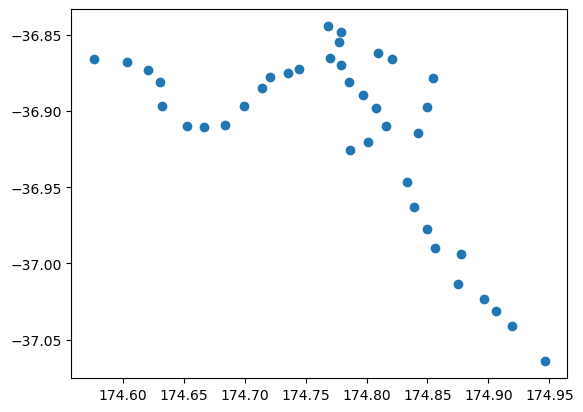

In [6]:
stations = gpd.read_file("data/transport/public_transport/trains_auckland_with_distances_on_network.gpkg")
stations['lon'] = stations['geometry'].x
stations['lat'] = stations['geometry'].y
stations["node"] = stations.geometry.apply(lambda x: ox.distance.nearest_nodes(G, x.x, x.y))
stations = gpd.GeoDataFrame(stations, geometry = stations.geometry)
stations.plot()

### Import the centroids of urban Auckland SA1s

In [9]:
sa1 = gpd.read_file("data/geographic/sa1_centorids_clean.gpkg")
sa1 = gpd.GeoDataFrame(sa1, geometry = sa1.geometry)
sa1 = sa1.to_crs(stations.crs)
sa1["node"] = sa1.geometry.apply(lambda x: ox.distance.nearest_nodes(G, x.x, x.y))                                                                         

sa1.head(3)

KeyboardInterrupt: 

### Calculate distances for each point


In [ ]:
# define function to acquire path
def get_path(G, origin, dest):
    path=ox.shortest_path(G, origin, dest, weight='travel_time') 
    return path

# define function to acquire path length
def get_path_len(G, path):
    path = sum(ox.utils_graph.get_route_edge_attributes(G, path, 'length'))
    return path

In [ ]:
distances = []
for pidx, point in enumerate(sa1.itertuples()):
    path_lengths = []

    for sidx, station in enumerate(stations.itertuples()):
        # get path
        path = get_path(G, sa1['node'].iloc[pidx], stations['node'].iloc[sidx])
        path_len = get_path_len(G, path)
        path_lengths.append(path_len)
        
    min_dist_to_station = min(path_lengths)
    distances.append(min_dist_to_station)

sa1['dist_station'] = distances
sa1.head(10)

In [ ]:
fig, ax = plt.subplots(figsize=(15, 15))
grid.plot(ax=ax, alpha=0.7, color="pink")
#stations.plot(ax=ax)

In [ ]:
sa1.to_file("data/sa1_station_dists.gpkg", driver="GPKG")

